# Compare SiFTO with Piscola

In [17]:
import piscola as pisco

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import pickle
with open('rcparams.pickle', 'rb') as file:
    rcparams = pickle.load(file)
    plt.rcParams.update(rcparams)

In [30]:
pisco_df = pd.read_csv(f'sifto_sample.csv')
sifto_df = pd.read_csv('test_files/Sifto/sifto.dat', delim_whitespace=True)
sifto_df.columns = ['sn'] + list(sifto_df.columns.values[1:])

sifto_values = sifto_df[sifto_df.sn.isin(pisco_df.sn.values)].sort_values('sn')
pisco_values = pisco_df[pisco_df.sn.isin(sifto_df.sn.values)].sort_values('sn')

pisco_values.shape

(185, 9)

In [7]:
lowz_idx = [i for i, sn in enumerate(pisco_values.sn.values) if sn.startswith('sn')]
sdss_idx = [i for i, sn in enumerate(pisco_values.sn.values) if sn.startswith('SDSS')]
snls_idx = [i for i, sn in enumerate(pisco_values.sn.values) if sn.startswith('0')]
hst_idx = [i for i, sn in enumerate(pisco_values.sn.values) if sn=='Ombo']

In [13]:
bessell_sne = []
shooter2_sne = []
swope_sne = []
keplercam_sne = []
sdss_sne = []
snls_sne = []
hst_sne = []

bessell_mean = 0.0
shooter2_mean = 0.0
swope_mean = 0.0
keplercam_mean = 0.0
sdss_mean = 0.0
snls_mean = 0.0
hst_mean = 0.0

diff = sifto_values.mb.values - pisco_values.mb.values

for i, sn in enumerate(pisco_values.sn.values):
    s = pisco.load_sn(sn, path='obj/')
    #print(s.bands)
    if 'Bessell_B' in s.bands:
        bessell_sne.append(s.name)
        bessell_mean += diff[i]
    elif 'B_4Shooter2' in s.bands:
        shooter2_sne.append(s.name)
        shooter2_mean += diff[i]
    elif 'B_swope' in s.bands:
        swope_sne.append(s.name)
        swope_mean += diff[i]
    elif 'B_Keplercam' in s.bands:
        keplercam_sne.append(s.name)
        keplercam_mean += diff[i]
    elif 'g_2.5m' in s.bands:
        sdss_sne.append(s.name)
        sdss_mean += diff[i]
    elif 'gsSAGEMrf4' in s.bands or 'rsSAGEMrf4' in s.bands:
        snls_sne.append(s.name)
        if np.abs(diff[i])<=0.5:
            snls_mean += diff[i]
        else:
            snls_mean += 0
    else:
        hst_sne.append(s.name)
        hst_mean += diff[i]

if len(bessell_sne)>0:
    bessell_mean /= len(bessell_sne)
if len(shooter2_sne)>0:
    shooter2_mean /= len(shooter2_sne)
if len(swope_sne)>0:
    swope_mean /= len(swope_sne)
if len(keplercam_sne)>0:
    keplercam_mean /= len(keplercam_sne)
if len(sdss_sne)>0:
    sdss_mean /= len(sdss_sne)
if len(snls_sne)>0:
    snls_mean /= len(snls_sne)
if len(hst_sne)>0:
    hst_mean /= len(hst_sne)

mb_shifts = []
color = []  # for plot display
for sn in pisco_values.sn.values:
    if sn in bessell_sne:
        mb_shifts.append(bessell_mean)
        color.append(0)
    elif sn in shooter2_sne:
        mb_shifts.append(shooter2_mean)
        color.append(1)
    elif sn in swope_sne:
        mb_shifts.append(swope_mean)
        color.append(2)
    elif sn in keplercam_sne:
        mb_shifts.append(keplercam_mean)
        color.append(3)
    elif sn in sdss_sne:
        mb_shifts.append(sdss_mean)
        color.append(4)
    elif sn in snls_sne:
        mb_shifts.append(snls_mean)
        color.append(5)
    elif sn in hst_sne:
        mb_shifts.append(hst_mean)
        color.append(6)

mb_shifts = np.asarray(mb_shifts)
color = np.asarray(color)
print(f'bessell:{len(bessell_sne)}; 4shooter2:{len(shooter2_sne)}; swope:{len(swope_sne)}; keplercam:{len(keplercam_sne)}; sdss:{len(sdss_sne)}; snls:{len(snls_sne)}; hst:{len(hst_sne)}')
print(f'Total of {len(bessell_sne) + len(shooter2_sne) + len(swope_sne) + len(keplercam_sne) + len(sdss_sne) + len(snls_sne) + len(hst_sne)} SNe')
print(np.unique(mb_shifts))

bessell:24; 4shooter2:10; swope:8; keplercam:25; sdss:85; snls:32; hst:1
Total of 185 SNe
[-0.0334024  -0.01533532 -0.01447827 -0.00644638 -0.00540527 -0.00075985
  0.01718487]


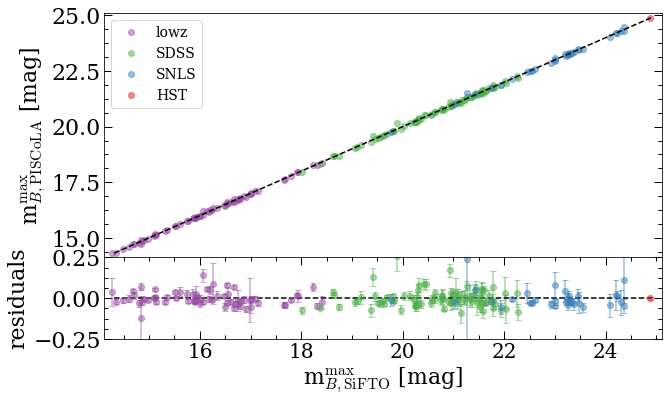

In [25]:
new_palette = [plt.get_cmap('Dark2')(i) for i in np.arange(8)] + [plt.get_cmap('Set1')(i) for i in np.arange(8)]
new_palette = new_palette[::-1][4:]
samples = {'lowz':lowz_idx, 'SDSS':sdss_idx, 'SNLS':snls_idx, 'HST':hst_idx}

f, ax = plt.subplots(2, 1, figsize=(10,6), gridspec_kw = {'height_ratios':[3, 1]})
f.subplots_adjust(hspace=0)

svals = sifto_values.mb.values
pvals = pisco_values.mb.values + mb_shifts
pvals_err = pisco_values.dmb.values

line = np.arange(np.nanmin(pvals), np.nanmax(pvals)+0.1, 0.1)
for i, item in enumerate(samples.items()):
    sample, idx = item
    ax[0].plot(svals[idx], pvals[idx], 'o', color=new_palette[i], alpha=0.5, label=sample)
ax[0].plot(line, line, '--k')

ax[0].set_ylabel(r'm$_{B \rm, PISCoLA}^{\rm max}$ [mag]')
ax[0].get_xaxis().set_visible(False)
ax[0].set_xlim(line.min()-0.2, line.max()+0.2)
ax[0].set_ylim(line.min()-0.2, line.max()+0.2)
ax[0].legend(fontsize=14)


for i, item in enumerate(samples.items()):
    sample, idx = item
    ax[1].errorbar(svals[idx], (pvals-svals)[idx], yerr=pvals_err[idx], capsize=3, fmt='o', color=new_palette[i], alpha=0.5)

ax[1].plot(line, np.zeros_like(line), '--k')
ax[1].set_xlabel(r'm$_{B \rm, SiFTO}^{\rm max}$ [mag]')
ax[1].set_ylabel(r'residuals')
ax[1].set_xlim(line.min()-0.2, line.max()+0.2)
ax[1].set_ylim(-0.25, 0.25)

#plt.savefig('plots/mb_comparison_sifto.pdf')
#plt.tight_layout()
plt.show()

In [33]:
bessell_sne = []
shooter2_sne = []
swope_sne = []
keplercam_sne = []
sdss_sne = []
snls_sne = []

bessell_mean = 0.0
shooter2_mean = 0.0
swope_mean = 0.0
keplercam_mean = 0.0
sdss_mean = 0.0
snls_mean = 0.0

diff = sifto_values.color.values - pisco_values.color.values
sdss_corr = 0
snls_corr = 0
N = [0, 0, 0, 0] # number of SNe in each sample

for i, sn in enumerate(pisco_values.sn.values):
    s = pisco.load_sn(sn, path='obj/')
    
    if 'Bessell_B' in s.bands:
        bessell_sne.append(s.name)
        bessell_mean = np.nansum([bessell_mean, diff[i]])
        if s.lc_parameters['colour']>-100:
            N[0] += 1
    elif 'B_4Shooter2' in s.bands:
        shooter2_sne.append(s.name)
        shooter2_mean = np.nansum([shooter2_mean, diff[i]])
        if s.lc_parameters['colour']>-100:
            N[0] += 1
    elif 'B_swope' in s.bands:
        swope_sne.append(s.name)
        swope_mean = np.nansum([swope_mean, diff[i]])
        if s.lc_parameters['colour']>-100:
            N[0] += 1
    elif 'B_Keplercam' in s.bands:
        keplercam_sne.append(s.name)
        keplercam_mean = np.nansum([keplercam_mean, diff[i]])
        if s.lc_parameters['colour']>-100:
            N[0] += 1
    elif 'g_2.5m' in s.bands:
        sdss_sne.append(s.name)
        if np.abs(diff[i])<0.5:
            sdss_corr += 1
            sdss_mean = np.nansum([sdss_mean, diff[i]])
        if s.lc_parameters['colour']>-100:
            N[1] += 1
    elif 'gsSAGEMrf4' in s.bands or 'rsSAGEMrf4' in s.bands:
        snls_sne.append(s.name)
        if np.abs(diff[i])<0.5:
            snls_corr += 1
            snls_mean = np.nansum([snls_mean, diff[i]])
        if s.lc_parameters['colour']>-100:
            N[2] += 1

if len(bessell_sne)>0:
    bessell_mean /= len(bessell_sne)
if len(shooter2_sne)>0:
    shooter2_mean /= len(shooter2_sne)
if len(swope_sne)>0:
    swope_mean /= len(swope_sne)
if len(keplercam_sne)>0:
    keplercam_mean /= len(keplercam_sne)
if len(sdss_sne)>0:
    sdss_mean = sdss_mean/sdss_corr
if len(snls_sne)>0:
    snls_mean = snls_mean/snls_corr

color_shifts = []

for sn in pisco_values.sn.values:
    if sn in bessell_sne:
        color_shifts.append(bessell_mean)
        #color2.append(0)
    elif sn in shooter2_sne:
        color_shifts.append(shooter2_mean)
        #color2.append(1)
    elif sn in swope_sne:
        color_shifts.append(swope_mean)
        #color2.append(2)
    elif sn in keplercam_sne:
        color_shifts.append(keplercam_mean)
        #color2.append(3)
    elif sn in sdss_sne:
        color_shifts.append(sdss_mean)
        #color2.append(4)
    elif sn in snls_sne:
        color_shifts.append(snls_mean)
        #color2.append(5)
    else:
        color_shifts.append(0.0)
        #color2.append(6)

color_shifts = np.asarray(color_shifts)
print(f'bessell:{len(bessell_sne)}; 4shooter2:{len(shooter2_sne)}; swope:{len(swope_sne)}; keplercam:{len(keplercam_sne)}; sdss:{len(sdss_sne)}; snls:{len(snls_sne)}')
print(f'Total of {len(bessell_sne) + len(shooter2_sne) + len(swope_sne) + len(keplercam_sne) + len(sdss_sne) + len(snls_sne)} SNe')
print(np.unique(color_shifts))
print(N)

bessell:24; 4shooter2:10; swope:8; keplercam:25; sdss:85; snls:32
Total of 184 SNe
[-0.00594821 -0.00371347  0.          0.01139003  0.01471257  0.02379185
  0.0250298 ]
[64, 47, 14, 0]


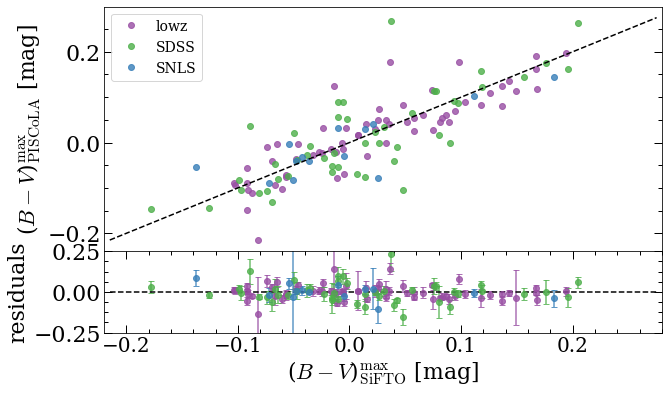

In [40]:
fontsize = 16

f, ax = plt.subplots(2, 1, figsize=(10,6), gridspec_kw = {'height_ratios':[3, 1]})
f.subplots_adjust(hspace=0)

svals = sifto_values.color.values
pvals = pisco_values.color.values + color_shifts
pvals_err = pisco_values.dcolor.values

line = np.arange(np.nanmin(pvals), np.nanmax(pvals)+0.01, 0.01)
for i, item in enumerate(samples.items()):
    sample, idx = item
    if sample!='HST':
        ax[0].plot(svals[idx], pvals[idx], 'o', color=new_palette[i], alpha=0.8, label=sample)
    
ax[0].plot(line, line, '--k')
ax[0].set_ylabel(r'($B-V$)$^{\rm max}_{\rm PISCoLA}$ [mag]')
ax[0].get_xaxis().set_visible(False)

ax[0].set_xlim(line.min()-0.005, line.max()+0.005)
ax[0].set_xlim(line.min()-0.005, line.max()+0.005)
ax[0].legend(fontsize=14)


for i, item in enumerate(samples.items()):
    sample, idx = item
    ax[1].errorbar(svals[idx], (pvals-svals)[idx], yerr=pvals_err[idx], capsize=3, fmt='o', color=new_palette[i], alpha=0.8)
    
ax[1].plot(line, np.zeros_like(line), '--k')
ax[1].set_xlabel(r'($B-V$)$^{\rm max}_{\rm SiFTO}$ [mag]')
ax[1].set_ylabel(r'residuals')
ax[1].set_xlim(line.min()-0.005, line.max()+0.005)
ax[1].set_ylim(-0.25, 0.25)

#plt.savefig('plots/colour_comparison_sifto.pdf')
plt.show()